In [69]:
#### Start of the Slippage Analysis

# Empirical slippage analysis
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

vol_window=30

# token0 is usdc, token1 is eth
def process_uni_eth_trades(data1,name):
    data1.rename(columns={"amoun0_adjusted":"amount0_adjusted"},inplace=True)
    data1["amount1_adjusted"]=data1["amount1_adjusted"].apply(lambda x: abs(x/1.0e12))
    data1["amount0_adjusted"]=data1["amount0_adjusted"].apply(lambda x: abs(x*1.0e12))
    data1["price_implied"] = 1e24/data1["price_implied"]
    data1["price_actual"] = 1e24/data1["price_actual"]
    data1["previous_price_actual"] = 1e24/data1["previous_price_actual"]
    data1["price_impact"]=100*abs(data1["price_actual"]-data1["previous_price_actual"])/data1["previous_price_actual"]
    data1["evt_block_time"] = pd.to_datetime(data1['evt_block_time'], utc=True)
    data1['unix_timestamp'] = data1['evt_block_time'].astype(int) // 10**9
    data1.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    data1['date'] = pd.to_datetime(data1['unix_timestamp'], unit='s').dt.date
    df = data1.groupby(["date"]).agg({"price_impact": "std","unix_timestamp":["first","last"],"price_actual":"mean"}).rename(columns={"price_impact": "volatility"})    
    df_reset = df.reset_index()
    df_reset.columns = ['_'.join(col).rstrip('_') for col in df_reset.columns.values]
    df_reset['rolling_volatility'] = df_reset['volatility_std'].rolling(window=vol_window).mean()*((252 ** 0.5))
    # df_reset["std_price"] = df_reset['price_actual_mean'].rolling(window=7).apply(lambda x: np.std(x))/df_reset['price_actual_mean'].rolling(window=7).mean()

   # Then, perform the asof merge
    merged_df = pd.merge_asof(data1, df_reset, left_on='unix_timestamp', right_on='unix_timestamp_first',direction='backward')
    merged_df = merged_df.dropna()
    merged_df["new_cross_impact"]=merged_df["rolling_volatility"]*merged_df["amount1_adjusted"]
    print(merged_df.columns,merged_df.shape)

    plt.figure()
    # plt.plot(merged_df["date_x"],merged_df["std_price"]/merged_df["price_actual_mean"], label='std_price')
    plt.plot(merged_df["date_x"],merged_df["rolling_volatility"],label='rolling_volatility')
    plt.scatter(merged_df["date_x"],merged_df["price_impact"],label='price_impact',alpha=0.1,c=merged_df["amount1_adjusted"],cmap='viridis')
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label('Trade Size')
    plt.show()

    plt.figure()
    # plt.plot(merged_df["date_x"],merged_df["std_price"]/merged_df["price_actual_mean"], label='std_price')
    plt.plot(merged_df["date_x"],merged_df["rolling_volatility"],label='rolling_volatility')
    plt.scatter(merged_df["date_x"],1e3*merged_df["price_impact"]/merged_df["amount1_adjusted"],label='price_impact/trade_size',alpha=0.1,c=merged_df["rolling_volatility"],cmap='viridis')
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label('rolling_volatility')
    plt.show()

    plt.figure()
    plt.scatter(merged_df["amount1_adjusted"],merged_df["price_movement_percentage"],c=merged_df["rolling_volatility"],cmap='viridis')
    plt.title(name)
    plt.show()

    plt.figure()
    plt.plot(merged_df["unix_timestamp"],merged_df["price_actual"])    
    plt.title(name)
    plt.show()
    return(merged_df)

# token0 is usdc, token1 is usdt
def process_uni_stable_trades(data1, name):
    data1.rename(columns={"amoun0_adjusted":"amount0_adjusted"},inplace=True)
    data1.rename(columns={"amoun1_adjusted":"amount0_adjusted"},inplace=True)
    data1["amount1_adjusted"]=data1["amount1_adjusted"].apply(lambda x: abs(x))
    data1["amount0_adjusted"]=data1["amount0_adjusted"].apply(lambda x: abs(x))
    data1["price_implied"] = 1/data1["price_implied"]
    data1["price_actual"] = 1/data1["price_actual"]
    data1["previous_price_actual"] = 1/data1["previous_price_actual"]
    data1["price_impact"]=100*abs(data1["price_actual"]-data1["previous_price_actual"])/data1["previous_price_actual"]
    data1["evt_block_time"] = pd.to_datetime(data1['evt_block_time'], utc=True)
    data1['unix_timestamp'] = data1['evt_block_time'].astype(int) // 10**9
    data1.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    data1['date'] = pd.to_datetime(data1['unix_timestamp'], unit='s').dt.date
    df = data1.groupby(["date"]).agg({"price_impact": "std","unix_timestamp":["first","last"],"price_actual":"mean"}).rename(columns={"price_impact": "volatility"})    
    df_reset = df.reset_index()
    df_reset.columns = ['_'.join(col).rstrip('_') for col in df_reset.columns.values]
    df_reset['rolling_volatility'] = df_reset['volatility_std'].rolling(window=vol_window).mean()*((252 ** 0.5))
    # df_reset["std_price"] = df_reset['price_actual_mean'].rolling(window=7).apply(lambda x: np.std(x))/df_reset['price_actual_mean'].rolling(window=7).mean()
    
    # Then, perform the asof merge
    merged_df = pd.merge_asof(data1, df_reset, left_on='unix_timestamp', right_on='unix_timestamp_first',direction='backward')
    merged_df = merged_df.dropna()
    merged_df["new_cross_impact"]=merged_df["rolling_volatility"]*merged_df["amount1_adjusted"]
    print(merged_df.columns,merged_df.shape)

    plt.figure()
    # plt.plot(merged_df["date_x"],merged_df["std_price"]/merged_df["price_actual_mean"], label='std_price')
    plt.plot(merged_df["date_x"],merged_df["rolling_volatility"],label='rolling_volatility')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(merged_df["amount1_adjusted"],merged_df["price_movement_percentage"],c=merged_df["rolling_volatility"],cmap='viridis')
    plt.show()

    plt.figure()
    plt.plot(merged_df["unix_timestamp"],merged_df["price_actual"])    
    plt.show()
    return(merged_df)

def gen_multi_var_reg(df, x_vars, y_var):    
    # Define input (X) and output (y) variables
    X = df[x_vars]
    y = df[y_var]

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # # Get the summary
    # print(model.summary())

    # # To get individual components (parameters, R-squared, etc.)
    # print("Parameters:", model.params)
    # print("R-squared:", model.rsquared)
    return model

def lin_reg(df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility"):
    print("lin_reg")
    # Linear regression
    # Generate Y-values based on the regression model
    p, cov = np.polyfit(df[x_var], df[y_var], 1, cov=True)  # Assuming x and y are your data arrays
    slope = p[0]
    intercept = p[1]
    errors = np.sqrt(np.diag(cov))
    y_fit = slope * df[x_var] + intercept
    print(slope,intercept,errors)
    plt.scatter(x=df[x_var], y=df[y_var], label='Data', c=df[color_var], cmap='viridis')
    plt.plot(df[x_var], y_fit, label=f'Fit: y = {slope:.6f}x + {intercept:.6f}', color='firebrick')
    if x_var=="amount1_adjusted":
        plt.xlabel("Trade Size")
    else:
        plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label(color_var)
    plt.show()
    return(p, cov)

def plot_3d_relationships(df,x_var,y_var,z_var):
    if x_var=="amount1_adjusted": 
        x_var_name = "Trade Size"
        df[x_var+'_bin'] = df[x_var].round()
    else:
        x_var_name = y_var
        df[x_var+'_bin'] = df[x_var].round(2)
        
    df[y_var+'_bin'] = df[y_var].round(4)
    df[z_var+'_bin'] = df[z_var].round(0)
    
    df2=df.groupby([x_var+'_bin',y_var+'_bin']).agg({z_var: "mean"}).reset_index()
    fig = px.scatter(df2,x=x_var+'_bin',y=z_var,color=y_var+'_bin')
    fig.update_layout(
        xaxis=dict(type='linear', title=x_var_name+"_bin"),
        yaxis=dict(type='linear', title=z_var),
        title_text=x_var_name+'_bin vs'+z_var
    )
    fig.show()

    df3=df.groupby([y_var+'_bin',x_var+'_bin']).agg({z_var: "mean"}).reset_index()   
    fig = px.scatter(df3,x=y_var+'_bin',y=z_var,color=x_var+'_bin')
    fig.update_layout(
        xaxis=dict(type='linear', title=y_var+"_bin"),
        yaxis=dict(type='linear', title=z_var),
        title_text=y_var+'_bin vs '+z_var
    )
    fig.show()

Index(['amount0_adjusted', 'amount1_adjusted', 'price_implied', 'price_actual',
       'previous_price_actual', 'price_movement_percentage', 'evt_tx_hash',
       'evt_block_number', 'evt_block_time', 'evt_index', 'price_impact',
       'unix_timestamp', 'date_x', 'date_y', 'volatility_std',
       'unix_timestamp_first', 'unix_timestamp_last', 'price_actual_mean',
       'rolling_volatility', 'new_cross_impact'],
      dtype='object') (340687, 20)


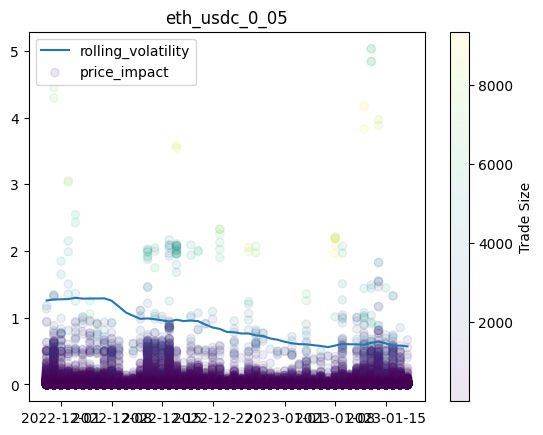

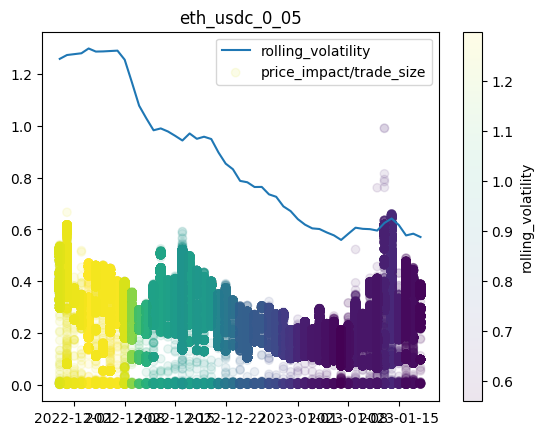

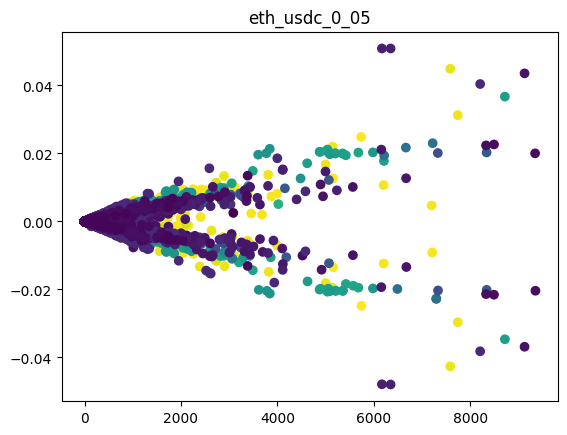

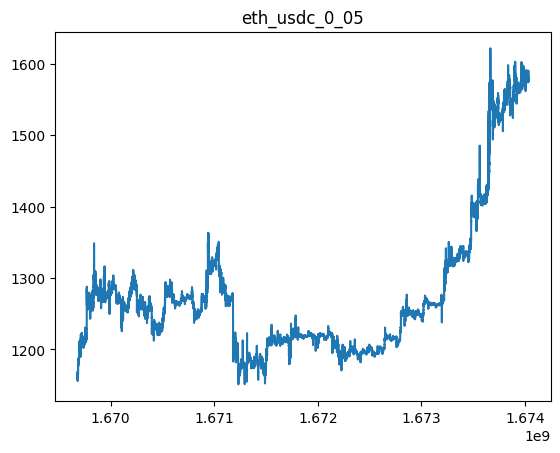

Index(['amount0_adjusted', 'amount1_adjusted', 'price_implied', 'price_actual',
       'previous_price_actual', 'price_movement_percentage', 'evt_tx_hash',
       'evt_block_number', 'evt_block_time', 'evt_index', 'price_impact',
       'unix_timestamp', 'date_x', 'date_y', 'volatility_std',
       'unix_timestamp_first', 'unix_timestamp_last', 'price_actual_mean',
       'rolling_volatility', 'new_cross_impact'],
      dtype='object') (93238, 20)


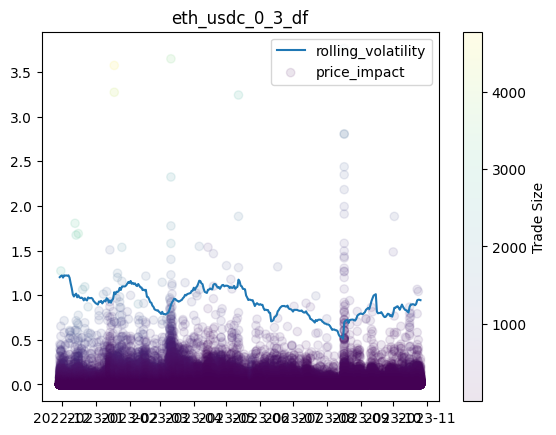

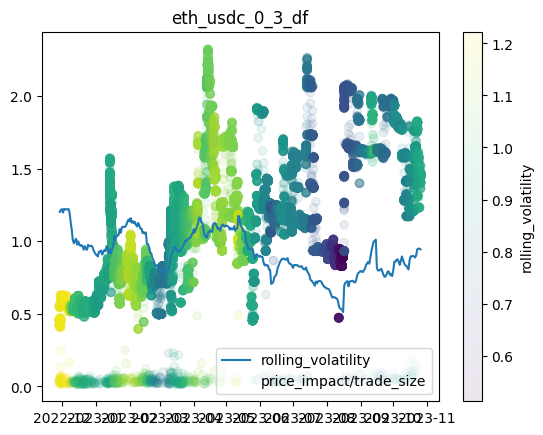

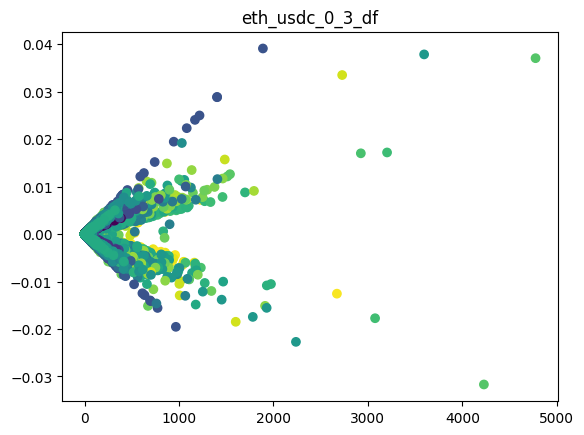

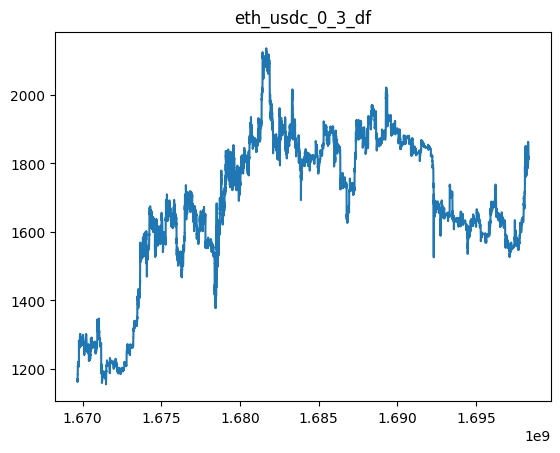

Index(['amount0_adjusted', 'amount1_adjusted', 'price_implied', 'price_actual',
       'previous_price_actual', 'price_movement_percentage', 'evt_tx_hash',
       'evt_block_number', 'evt_block_time', 'evt_index', 'price_impact',
       'unix_timestamp', 'date_x', 'date_y', 'volatility_std',
       'unix_timestamp_first', 'unix_timestamp_last', 'price_actual_mean',
       'rolling_volatility', 'new_cross_impact'],
      dtype='object') (287451, 20)


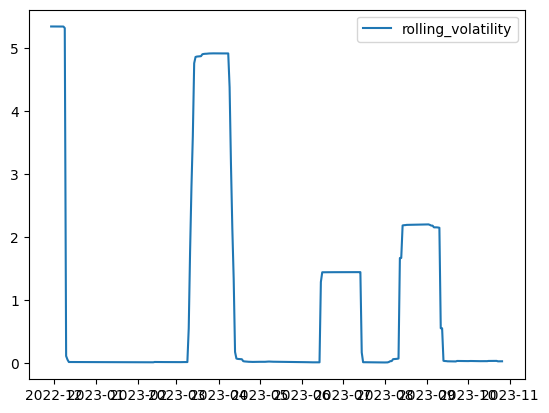

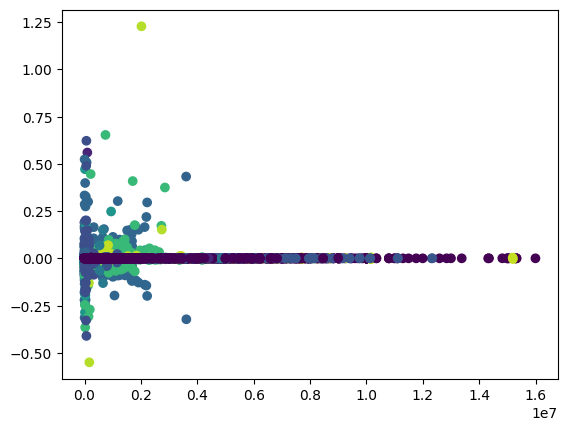

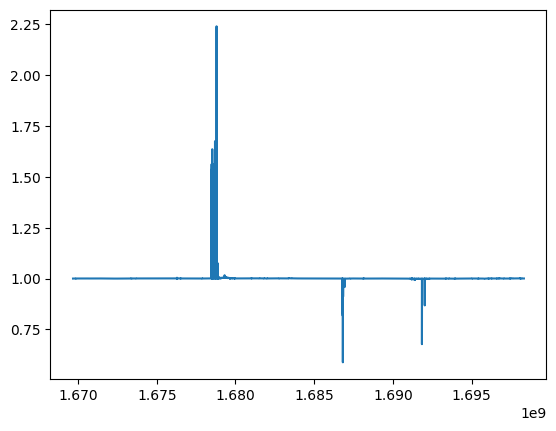

Index(['amount0_adjusted', 'amount1_adjusted', 'price_implied', 'price_actual',
       'previous_price_actual', 'price_movement_percentage', 'evt_tx_hash',
       'evt_block_number', 'evt_block_time', 'evt_index', 'price_impact',
       'unix_timestamp', 'date_x', 'date_y', 'volatility_std',
       'unix_timestamp_first', 'unix_timestamp_last', 'price_actual_mean',
       'rolling_volatility', 'new_cross_impact'],
      dtype='object') (81119, 20)


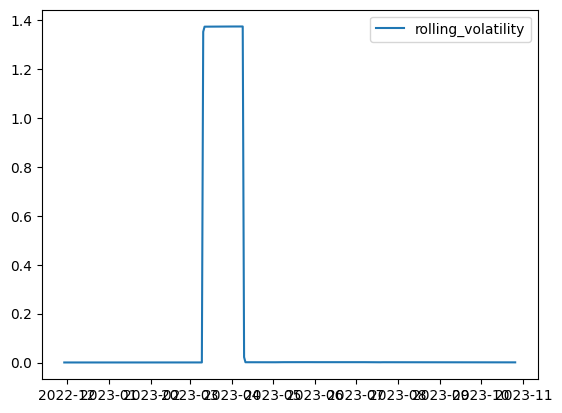

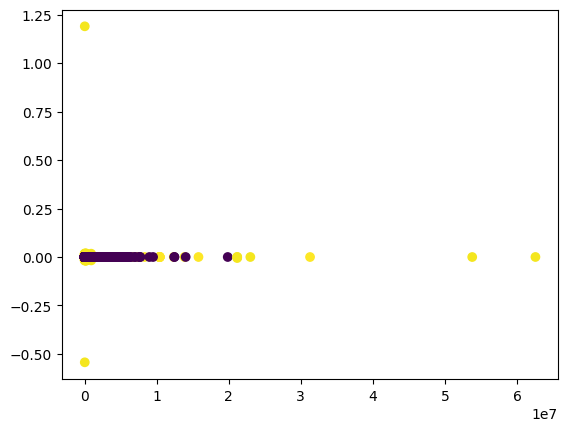

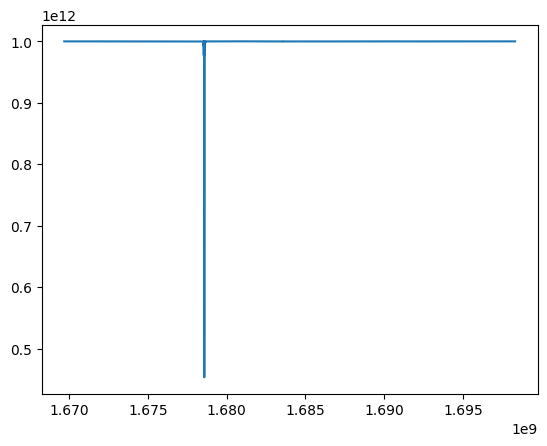

In [71]:
with open("../data/slippage/eth_usdc_0_05.csv","r") as infile:
    data1 = pd.read_csv(infile)
eth_usdc_0_05_df = process_uni_eth_trades(data1,"eth_usdc_0_05")

with open("../data/slippage/eth_usdc_0_3.csv","r") as infile:
    data3 = pd.read_csv(infile)
eth_usdc_0_3_df = process_uni_eth_trades(data3,"eth_usdc_0_3_df")

with open("../data/slippage/usdct_usdt_0_01.csv","r") as infile:
    data2 = pd.read_csv(infile)
usdct_usdt_0_01_df = process_uni_stable_trades(data2,name="usdct_usdt_0_01")

with open("../data/slippage/dai_usdc_0_01.csv","r") as infile:
    data4 = pd.read_csv(infile)
dai_usdc_0_01_df = process_uni_stable_trades(data4,name="dai_usdc_0_01")

/var/folders/0c/f8mzvlf17x9brkzz58g4tpn80000gn/T/ipykernel_65103/27163847.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



rsquared 0.8490126225008171
rsquared_adj 0.8490117361229567
intercept -0.004747041368502658
slopes rolling_volatility    0.004062
amount1_adjusted      0.000314
dtype: float64
lin_reg
0.00031396192184984404 -0.0012232340408151428 [2.27188652e-07 3.63701515e-05]


/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



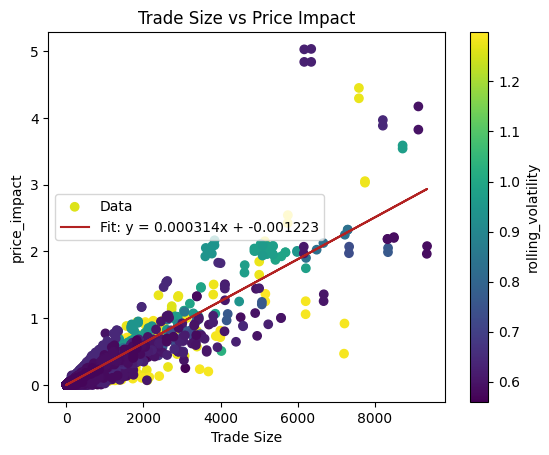

lin_reg
0.00033793605479175647 -0.0006527097063911044 [2.80416533e-07 4.06923300e-05]


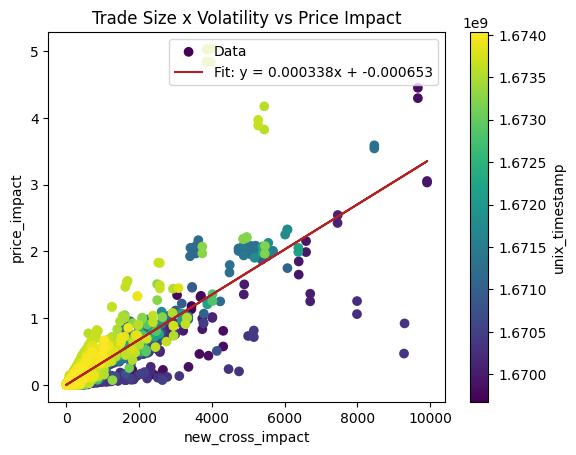

In [72]:
ols1 = gen_multi_var_reg(eth_usdc_0_05_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[1:]    # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared",ols1.rsquared)
print("rsquared_adj",ols1.rsquared_adj)
print("intercept",intercept)
print("slopes",slopes)

p,cov = lin_reg(eth_usdc_0_05_df, x_var="amount1_adjusted", y_var="price_impact",name="Trade Size vs Price Impact",color_var="rolling_volatility")
slope = p[0]
intercept = p[1]
errors = np.sqrt(np.diag(cov))
y_fit = slope * eth_usdc_0_05_df["amount1_adjusted"] + intercept

p,cov = lin_reg(eth_usdc_0_05_df, x_var="new_cross_impact", y_var="price_impact",name="Trade Size x Volatility vs Price Impact",color_var="unix_timestamp")
slope = p[0]
intercept = p[1]
errors = np.sqrt(np.diag(cov))
y_fit = slope * eth_usdc_0_05_df["new_cross_impact"] + intercept

plot_3d_relationships(df=eth_usdc_0_3_df,x_var="amount1_adjusted",y_var="rolling_volatility",z_var="price_impact")

In [ ]:
ols2 = gen_multi_var_reg(eth_usdc_0_3_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols2)

In [ ]:
ols3 = gen_multi_var_reg(usdct_usdt_0_01_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols3)

In [ ]:
ols4 = gen_multi_var_reg(dai_usdc_0_01_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols4)

In [ ]:
lin_reg(eth_usdc_0_05_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")
lin_reg(eth_usdc_0_3_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")

lin_reg(usdct_usdt_0_01_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")
lin_reg(dai_usdc_0_01_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")

In [ ]:
lin_reg(eth_usdc_0_3_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")
lin_reg(usdct_usdt_0_01_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")
lin_reg(dai_usdc_0_01_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")

In [ ]:
# plot_3d_relationships(eth_usdc_0_05_df)
plot_3d_relationships(eth_usdc_0_3_df)
plot_3d_relationships(usdct_usdt_0_01_df)
# plot_3d_relationships(dai_usdc_0_01_df)

In [ ]:
import plotly.express as px
import numpy as np
# new slippage function based on empirical analysis
def quad_output(x):
    """
    @notice calculate price impact when selling x or y to the open market.
    Assuming that we trade against Uniswap is a conservative assumption
    """
    a,b,c = (2.602424822058012e-10,2.3009044333523045e-07,0.0004613261845851614)
    return(a*x**2+b*x+c)

x = np.logspace(-9,5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
y = [quad_output(x) for x in x]
fig=px.line(x=x, y=y)
fig.show()

def lin_output(x):
    return 1.081593506690093e-06*x+0.0004379110082802476

x = np.logspace(-9,5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
print(x)
y = [lin_output(x) for x in x]
fig=px.line(x=x, y=y)
fig.show()